[View in Colaboratory](https://colab.research.google.com/github/mikebelin/tensorflow/blob/master/TensorFlow_on_GPU_playground.ipynb)

# TensorFlow on GPU playground

## Introduction to Colab

In [0]:
import tensorflow as tf


### Install dependencies you need for your Python environment
Dependencies are added to your private virtual machine.

In [0]:
!pip install -q seaborn==0.9.0

Test that plotting libraries are working:

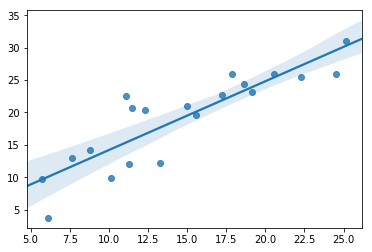

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Generate some random data
num_points = 20
# x will be 5, 6, 7... but also twiddled randomly
x = 5 + np.arange(num_points) + np.random.randn(num_points)
# y will be 10, 11, 12... but twiddled even more randomly
y = 10 + np.arange(num_points) + 5 * np.random.randn(num_points)
sns.regplot(x, y)

Using `sns.relplot` requires a new version of `seaborn` installed above (make sure you have restarted the runtime after installation).

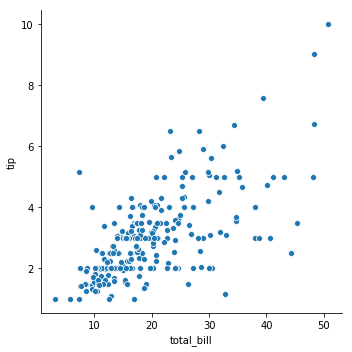

In [0]:
import seaborn as sns
tips = sns.load_dataset("tips")
sns.relplot(x="total_bill", y="tip", data=tips);
plt.show()

In [0]:
!ls

chap-11-ex-8  my_model.ckpt.data-00000-of-00001  my_model.ckpt.meta
checkpoint    my_model.ckpt.index		 sample_data


In [0]:
!nvidia-smi

Tue Sep 18 14:08:17 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    57W / 149W |  10936MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  


### Run TensorFlow on GPU 
Select "GPU" in the Runtime -> Change runtime in Notebook Settings. Then check that GPU is available.

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


List available devices:

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18226390409830666539
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281989632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9907313708245707620
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


Perform a simple computation on GPU:

In [0]:
import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(shape=(None), dtype=tf.float32, name='x')
y = 2*x
z = y+3

sess = tf.Session()

# graph = tf.get_default_graph()
z_val = sess.run(z, feed_dict={x: [1.0, 2.0]})
print(z_val)
sess.close()

# Prettier way without `sess.close()`
with tf.Session() as sess:
  z_val = sess.run(z, feed_dict={x: [2.0, 3.0]})
  print(z_val)




[5. 7.]
[7. 9.]


In [0]:
# Create a graph
tf.reset_default_graph()

# Place placeholders on CPU
with tf.device('/cpu:0'):
  a = tf.placeholder(shape=(None), dtype=tf.float32, name='a')
  b = tf.placeholder(shape=(None), dtype=tf.float32, name='b')

# Perform elementwise multiplication and reduce_sum on GPU (copying a and b values there under the hood)
with tf.device('/gpu:0'):
  c = tf.multiply(a, b, name='c')
  d = tf.reduce_sum(c, name='d')

 
# Creates a session with log_device_placement set to True.
with tf.Session(config=tf.ConfigProto(log_device_placement=True, allow_soft_placement=False)) as sess:
  # Add metadata options to see where operations where placed
  options = tf.RunOptions(output_partition_graphs=True)
  metadata = tf.RunMetadata()
  # Runs the op
  d_val = sess.run(d, options=options, run_metadata=metadata, 
                          feed_dict={a: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
                                    b: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]})
  print('Result: %f' % d_val)  
  
for partition_graph in metadata.partition_graphs:
  nodes = partition_graph.node
  for n in nodes:
    print('Name %s, op %s, device %s' % (n.name, n.op, n.device))
    # print(n)


Result: 91.000000
Name range/start, op Const, device /job:localhost/replica:0/task:0/device:GPU:0
Name range/delta, op Const, device /job:localhost/replica:0/task:0/device:GPU:0
Name _arg_a_0_0/_1, op _Recv, device /job:localhost/replica:0/task:0/device:GPU:0
Name _arg_b_0_1/_3, op _Recv, device /job:localhost/replica:0/task:0/device:GPU:0
Name c, op Mul, device /job:localhost/replica:0/task:0/device:GPU:0
Name Rank, op Rank, device /job:localhost/replica:0/task:0/device:GPU:0
Name range, op Range, device /job:localhost/replica:0/task:0/device:GPU:0
Name d, op Sum, device /job:localhost/replica:0/task:0/device:GPU:0
Name d/_4, op _Send, device /job:localhost/replica:0/task:0/device:GPU:0
Name _arg_a_0_0, op _Arg, device /job:localhost/replica:0/task:0/device:CPU:0
Name _arg_a_0_0/_0, op _Send, device /job:localhost/replica:0/task:0/device:CPU:0
Name _arg_b_0_1, op _Arg, device /job:localhost/replica:0/task:0/device:CPU:0
Name _arg_b_0_1/_2, op _Send, device /job:localhost/replica:0/tas

### Distributed TensorFlow (just horsing around, skip this for now)

In [0]:
c = tf.constant("Hello distributed TensorFlow!")
server = tf.train.Server.create_local_server()

In [0]:
with tf.Session(server.target) as sess:
    print(sess.run(c))

b'Hello distributed TensorFlow!'


In [0]:
cluster_spec = tf.train.ClusterSpec({
    "ps": [
        "127.0.0.1:2221",  # /job:ps/task:0
        # "127.0.0.1:2222",  # /job:ps/task:1
    ],
    "worker": [
        # "127.0.0.1:2223",  # /job:worker/task:0
        # "127.0.0.1:2224",  # /job:worker/task:1
        # "127.0.0.1:2225",  # /job:worker/task:2
    ]})
task_ps0 = tf.train.Server(cluster_spec, job_name="ps", task_index=0)

In [0]:
tf.reset_default_graph()

with tf.device("/job:ps"):
    a = tf.Variable(1.0, name="a")
    c = 2 * a

with tf.Session("grpc://127.0.0.1:2221") as sess:
  sess.run(a.initializer)
  print(c.eval())

# Observe TensorFlow speedup on GPU relative to CPU
Copied from the Colab examples.

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU to compare execution speed. Note that this takes a LOT of memory from GPU, so you may need to restart runtime if you encounter out-of-memory errors.

In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
8.487654705000296
GPU (s):
0.881815213000209
GPU speedup over CPU: 9x


## Further examples

### Train a classifier on MNIST dataset

Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz


(-0.5, 27.5, 27.5, -0.5)

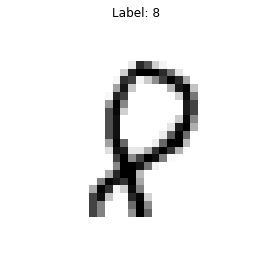

In [0]:
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/mnist/data")

train_images = mnist.train.images

digit_index = 3300

some_digit = mnist.train.images[digit_index]
some_digit_image = some_digit.reshape(28, 28)
some_digit_label = mnist.train.labels[digit_index]
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary)
plt.title('Label: %d' % some_digit_label)
plt.axis("off")

In [0]:
import tensorflow as tf

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") # Number of training samples in batch not known and not required
y = tf.placeholder(tf.int64, shape=(None), name="y") # y is a 1D array with unknown length

def neuron_layer(X, n_neurons, name, activation=lambda x: x):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1]) # Number of features
        stddev = 2 / np.sqrt(n_inputs + n_neurons) # Xavier initialization
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev) # Random initialization for weights
        W = tf.Variable(init, name="kernel") # Connection weights
        b = tf.Variable(tf.zeros([n_neurons]), name="bias") # Biases, can be initialized to zero
        Z = tf.matmul(X, W) + b # Size (n_batch, n_neurons), bias vector b added to each row (each sample)
        return activation(Z)


with tf.name_scope("ann"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs") # Unscaled as softmax computed later internally
    

with tf.name_scope("loss"):
    # This op expects unscaled logits, since it performs a softmax on logits internally for efficiency.
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

# Evaluate performance by checking if the correct label is in top 1:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/mnist/data")

n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy", acc_val)
    save_path = saver.save(sess, "./my_model.ckpt")

Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz
0 Train accuracy: 0.92 Val accuracy 0.9154
1 Train accuracy: 0.94 Val accuracy 0.9312
2 Train accuracy: 0.94 Val accuracy 0.9396
3 Train accuracy: 0.96 Val accuracy 0.9462
4 Train accuracy: 0.92 Val accuracy 0.9514
5 Train accuracy: 0.98 Val accuracy 0.9544
6 Train accuracy: 0.98 Val accuracy 0.9576
7 Train accuracy: 0.98 Val accuracy 0.9586
8 Train accuracy: 0.98 Val accuracy 0.9608
9 Train accuracy: 0.98 Val accuracy 0.9624
10 Train accuracy: 0.94 Val accuracy 0.9628
11 Train accuracy: 1.0 Val accuracy 0.966
12 Train accuracy: 0.98 Val accuracy 0.966
13 Train accuracy: 0.98 Val accuracy 0.969
14 Train accuracy: 0.96 Val accuracy 0.9694
15 Train accuracy: 0.96 Val accuracy 0.9712
16 Train accuracy: 0.96 Val accuracy 0.9708
17 Train accuracy: 0.98 Val accuracy 0.97
18 Train a

### Train a TensorFlow model with a [sklearn](http://scikit-learn.org/)-compatible class

In [0]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError
from datetime import datetime
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import os

class NeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, 
                 n_hidden_layers=5,
                 n_neurons=100, 
                 learning_rate=0.01, 
                 batch_size=100,
                 # n_epochs=10,
                 activation=tf.nn.elu, 
                 initializer=tf.variance_scaling_initializer(), 
                 random_state=42,
                 dropout_rate=None,
                 batch_norm_momentum=None,
                 root_logdir='chap-11-ex-8'):

        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        # self.n_epochs = n_epochs
        self.random_state = random_state
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self._session = None
        self.root_logdir = root_logdir
        
    def _build_hidden(self, inputs):
        for layer_index in range(self.n_hidden_layers):
            with tf.name_scope("hidden"):
                if self.dropout_rate is not None:
                    inputs = tf.layers.dropout(inputs, self.dropout_rate, name='hidden-drop-%d' % layer_index, training=self._training)
                inputs = tf.layers.dense(inputs, 
                                         self.n_neurons, 
                                         name='hidden-%d' % (layer_index + 1), 
                                         kernel_initializer=self.initializer)
                if self.batch_norm_momentum is not None:
                    inputs = tf.layers.batch_normalization(inputs, 
                                                           training=self._training, 
                                                           momentum=self.batch_norm_momentum,
                                                           name='hidden-%d-bn' % (layer_index + 1))
                inputs = self.activation(inputs, name='hidden-%d-out' % (layer_index + 1))
        return inputs
    
    def _build_graph(self, n_inputs, n_outputs):
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
        y = tf.placeholder(tf.int32, shape=(None), name='y')
        
        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None
            
        hidden_outputs = self._build_hidden(X)
        
        with tf.name_scope("logits"):
            logits = tf.layers.dense(hidden_outputs, n_outputs, kernel_initializer=self.initializer, name='logits')
            y_proba = tf.nn.softmax(logits, name='Y_proba')
        
        with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
            loss = tf.reduce_mean(xentropy, name='loss')
        
        with tf.name_scope("train"):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            training_op = optimizer.minimize(loss, name='training_op')
        
        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
            
        with tf.name_scope("summary"):
            loss_summary = tf.summary.scalar("loss", loss)
            acc_summary = tf.summary.scalar("accuracy", accuracy)
            
        summary = tf.summary.merge_all()
            
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        self._X = X
        self._y = y
        self._y_proba = y_proba
        self._loss = loss
        self._accuracy = accuracy
        self._training_op = training_op
        self._init = init
        self._saver = saver
        self._summary = summary
        
    def close_session(self):
        if self._session:
            self._session.close()
    
    @property
    def _logdir(self): 
        now = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
        return os.path.join(self.root_logdir, 'run-%s' % now)


    def fit(self, X, y, n_epochs=20, X_valid=None, y_valid=None):
        # print('Shape of X:', X.shape)
        # print('Shape of y:', y.shape)
        self.close_session()
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        # print(self.classes_)
        n_outputs = len(self.classes_)
        self.class_to_index_ = {label: index
                            for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        self._session = tf.Session(graph=self._graph)
        best_loss = np.infty
        
        logdir = self._logdir
        
        with self._session.as_default() as sess:
            train_writer = tf.summary.FileWriter(logdir + '/train', sess.graph)
            val_writer = tf.summary.FileWriter(logdir + '/val')
            self._init.run()
            # self._saver.save()
            for epoch in range(1, n_epochs + 1):
                rnd_idx = np.random.permutation(len(X))
                i_batch = 0
                train_loss_sum = 0
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    train_loss, summary, _ = sess.run([self._loss, self._summary, self._training_op], feed_dict=feed_dict)
                    train_loss_sum += train_loss
                    i_batch += 1
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                
                train_loss = train_loss_sum / i_batch
                train_writer.add_summary(summary, epoch)
                if epoch % 5 ==0 and X_valid is not None and y_valid is not None:
                    loss_val, acc_val, summary = sess.run([self._loss, self._accuracy, self._summary],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_loss = loss_val
                    val_writer.add_summary(summary, epoch)
                    print("{}\tTraining loss: {:.6f}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, train_loss, loss_val, best_loss, acc_val * 100))
            self._saver.save(sess, os.path.join(logdir, 'model_final.ckpt'))
            train_writer.close()
            val_writer.close()
        return self
    
    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

N_INPUTS = 28*28

MNIST = input_data.read_data_sets("/tmp/mnist/data")
X_train = MNIST.train.images
y_train = MNIST.train.labels
X_valid = MNIST.validation.images
y_valid = MNIST.validation.labels

nn_clf = NeuralNetworkClassifier(batch_norm_momentum=0.9, 
                                 dropout_rate=0.5,
                                 n_hidden_layers=2,
                                 n_neurons=100).fit(X_train, 
                                              y_train, 
                                              X_valid=X_valid,
                                              y_valid=y_valid, 
                                              n_epochs=10)

nn_clf.close_session()

Extracting /tmp/mnist/data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/data/t10k-labels-idx1-ubyte.gz
5	Training loss: 0.338314	Validation loss: 0.148714	Best loss: 0.148714	Accuracy: 95.62%
10	Training loss: 0.298836	Validation loss: 0.114671	Best loss: 0.114671	Accuracy: 96.66%


### Keras models can also use GPUs

In [0]:
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

['/job:localhost/replica:0/task:0/device:GPU:0']


In [0]:
from keras import layers, models
from keras.datasets import mnist
from keras.utils import to_categorical

# Load data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

def prepare_images(images):
    return images.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

# Reshape images and scale between zero and one
train_images = prepare_images(train_images)
test_images = prepare_images(test_images)

# Categorical encoding of class labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


11493376/11490434 [==============================] - 3s 0us/step


In [0]:
model = models.Sequential()

# Convolutional network

# In the first layers, learn patterns from 3x3 windows
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

print(model.summary())

used_images = 5000
history = model.fit(train_images[0:used_images], train_labels[0:used_images], epochs = 5, batch_size = 64, validation_split=0.20)
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy %.4f' % test_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                36928     
__________

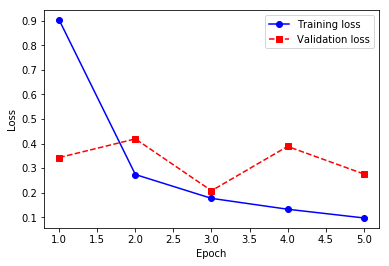

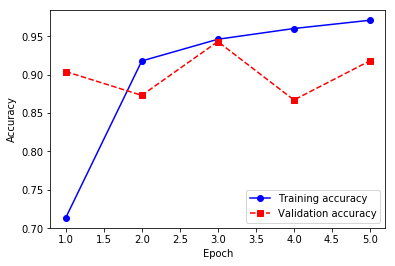

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = len(history.history['loss'])

plt.plot(range(1, epochs + 1), history.history['loss'], 'bo-', label = 'Training loss')
plt.plot(range(1, epochs + 1), history.history['val_loss'], 'rs--', label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(range(1, epochs + 1), history.history['acc'], 'bo-', label = 'Training accuracy')
plt.plot(range(1, epochs + 1), history.history['val_acc'], 'rs--', label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

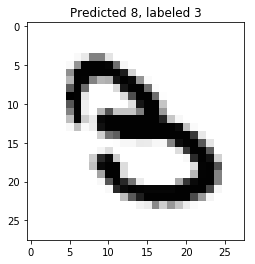

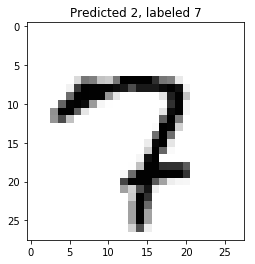

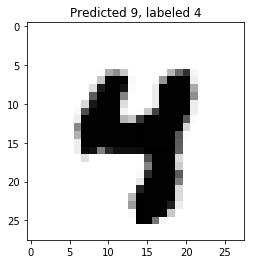

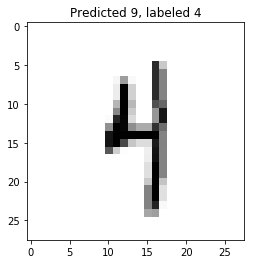

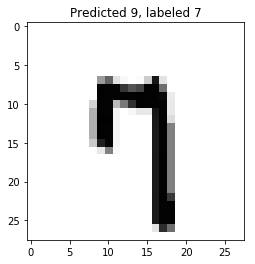

In [0]:
predicted_labels = to_categorical(model.predict_classes(test_images))

# Indices of failed predictions, there's probably a simpler way to do this
import numpy as np
failures = np.nonzero(np.sum(np.abs(predicted_labels - test_labels), axis = 1))[0]

import matplotlib.pyplot as plt
%matplotlib inline

def plot_for_ind(ind):
    img_failed = test_images[ind_failed]

    predicted_label = np.nonzero(predicted_labels[ind_failed])[0][0]
    labeled = np.nonzero(test_labels[ind_failed])[0][0]

    plt.imshow(np.reshape(img_failed, (28, 28)), cmap='Greys',  interpolation='nearest')

    plt.title('Predicted %d, labeled %d' % (predicted_label, labeled))
    plt.show()

# Visualize five of failed predictions
for ind_failed in failures[0:5]:
    plot_for_ind(ind_failed)